## We'll use the `Oxford-IIIT Pets` dataset with is 37 categories (breeds) of pets, roughly 200 images for each class. The images have a large variations in scale, pose and lighting.

In [150]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision import models, transforms

import matplotlib.pyplot as plt

In [183]:
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections.abc import Callable
from timeit  import default_timer as timer

In [60]:
!pip install torchinfo --quiet

In [61]:
from torchinfo import summary

## Setting Default Device

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Extracting the Dataset from Drive

In [8]:
import tarfile

with tarfile.open("/content/drive/MyDrive/oxford-iiit-pet.tgz", "r:gz") as tar:
    tar.extractall(path="/content/pet_dataset")

## Creating the Custom Dataset

In [117]:
class PetDataset(Dataset):
    def __init__(self, root: str, transform:transforms):
        super().__init__()

        self.root = root
        self.transform = transform
        self.files = list(Path(root).glob("*.jpg"))
        self.classes = list(set(" ".join(str(image_path).split('/')[-1].split('_')[:-1]).lower() for image_path in self.files))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        if (i < 0) or (i >= len(self.files)):
            raise IndexError

        img = self.transform(Image.open(self.files[i]).convert("RGB"))

        return img, self.classes.index(" ".join(str(self.files[i]).split('/')[-1].split('_')[:-1]).lower())

## Creating the Transformations

In [118]:
IMG_SIZE = 224
IMG_MEAN, IMG_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [119]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.Pad(padding=8, padding_mode="reflect"), # Adding Padding to the Image
    transforms.RandomCrop(size=(IMG_SIZE, IMG_SIZE)),  # Crop the Image at a Random Position
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

## Creating the Dataset

In [120]:
dataset = PetDataset("/content/pet_dataset/oxford-iiit-pet/images", data_transforms)

print(len(dataset))

7390


In [121]:
class_names = dataset.classes

print(len(class_names))
print(class_names)

37
['yorkshire terrier', 'sphynx', 'chihuahua', 'staffordshire bull terrier', 'shiba inu', 'bengal', 'american pit bull terrier', 'pomeranian', 'leonberger', 'beagle', 'german shorthaired', 'samoyed', 'havanese', 'japanese chin', 'english setter', 'russian blue', 'maine coon', 'basset hound', 'keeshond', 'english cocker spaniel', 'american bulldog', 'egyptian mau', 'great pyrenees', 'siamese', 'persian', 'saint bernard', 'scottish terrier', 'bombay', 'abyssinian', 'newfoundland', 'birman', 'miniature pinscher', 'boxer', 'wheaten terrier', 'ragdoll', 'british shorthair', 'pug']


## Visualize Images

In [122]:
# Creating a Denormalization Function
def denorm(image_batch, means, stds):
    if len(image_batch) == 3:
        image_batch = image_batch.unsqueeze(dim=0)

    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)

    return (image_batch * stds) + means

In [123]:
# Creating a Plotting Function
def show_image(img_tensor, label, means=IMG_MEAN, stds=IMG_STD):
    plt.imshow(denorm(img_tensor, means, stds).squeeze(dim=0).permute(1, 2, 0).cpu())
    plt.title(f"Label: {class_names[label]}")
    plt.axis(False);

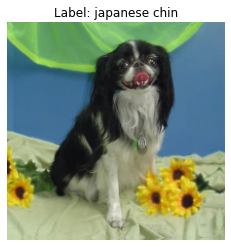

In [124]:
show_image(*dataset[931])

## Creating the Training and Validation Sets

In [125]:
VAL_PROP = 0.1
VAL_SIZE = int(len(dataset) * VAL_PROP)

train_ds, valid_ds = random_split(dataset, [len(dataset) - VAL_SIZE, VAL_SIZE])

print(len(train_ds), len(valid_ds))

6651 739


In [126]:
BATCH_SIZE = 256

train_dl = DataLoader(dataset=train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=os.cpu_count(),
                      pin_memory=True)
valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=os.cpu_count(),
                      pin_memory=True)

print(len(train_dl), len(valid_dl))

26 3


## Modifying a Pretrained Model (ResNet34)

In [128]:
# Taking a Look at the Model
model = models.resnet34()

summary(model,
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 224, 224]   [256, 1000]          --                   True
├─Conv2d (conv1)                         [256, 3, 224, 224]   [256, 64, 112, 112]  9,408                True
├─BatchNorm2d (bn1)                      [256, 64, 112, 112]  [256, 64, 112, 112]  128                  True
├─ReLU (relu)                            [256, 64, 112, 112]  [256, 64, 112, 112]  --                   --
├─MaxPool2d (maxpool)                    [256, 64, 112, 112]  [256, 64, 56, 56]    --                   --
├─Sequential (layer1)                    [256, 64, 56, 56]    [256, 64, 56, 56]    --                   True
│    └─BasicBlock (0)                    [256, 64, 56, 56]    [256, 64, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [256, 64, 56, 56]    [256, 64, 56, 56]    36,864               True
│    │    └─BatchN

In [222]:
def create_ResNet34(device):
    # Getting the Weights of the Pretrained Model
    weights = models.ResNet34_Weights.DEFAULT
    model = models.resnet34(weights=weights).to(device)

    # Freezing Parameters
    for param in model.parameters():
        param.requires_grad = False

    # Adjusting Output Layer
    model.fc = nn.Linear(in_features=model.fc.in_features,
                         out_features=37).to(device)

    model.name = "ResNet34"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [223]:
model = create_ResNet34(device)

[INFO] Created new ResNet34 model.


In [224]:
# Passing dummy data to the Model
model.eval()
with torch.inference_mode():
    logits = model(torch.randn(size=(BATCH_SIZE, 3, 224, 224), device=device))

print(logits[0])

tensor([ 0.3163, -0.1044, -0.5081,  0.2214,  0.5214, -1.0699, -0.8981,  0.6231,
         0.6768, -0.5305,  0.1623,  0.3626,  0.9135, -0.2471,  0.1604, -0.0513,
        -0.6851, -0.8901, -0.0204,  0.7208, -0.2817,  0.0602, -0.2207, -0.1600,
        -0.0134,  0.6355,  0.5678, -0.6991, -0.1537, -0.6137,  0.4165,  0.6442,
         0.2903,  0.5694, -0.0571,  0.3150,  0.1255], device='cuda:0')


## Creating Training/Evaluating Loop

In [225]:
def training_step(model: torch.nn.Module,
                  train_dl: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  eval_metric: Callable[[torch.Tensor, torch.Tensor]],
                  optim: torch.optim.Optimizer):
    
    batch_size = train_dl.batch_size
    model_device = next(model.parameters()).device
    train_loss, train_eval = 0, 0

    print("\tTraining Step: ", end="")

    model.train()
    for x_train, y_train in tqdm(train_dl):
        x_train, y_train = x_train.to(model_device, non_blocking=True), y_train.to(model_device, non_blocking=True)

        model_logits = model(x_train)

        loss = loss_fn(model_logits, y_train)
        train_loss += loss.item()
        train_eval += eval_metric(model_logits, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

    train_loss /= len(train_dl)
    train_eval /= len(train_dl)

    return train_loss, train_eval

In [226]:
def validation_step(model: torch.nn.Module,
                    valid_dl: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    eval_metric: Callable[[torch.Tensor, torch.Tensor]]):
    
    batch_size = valid_dl.batch_size
    model_device = next(model.parameters()).device
    valid_loss, valid_eval = 0, 0

    print("\tValidation Step: ", end="")

    model.eval()
    with torch.inference_mode():
        for x_valid, y_valid in tqdm(valid_dl):
            x_valid, y_valid = x_valid.to(model_device, non_blocking=True), y_valid.to(model_device, non_blocking=True)

            model_logits = model(x_valid)

            valid_loss += loss_fn(model_logits, y_valid).item()
            valid_eval += eval_metric(model_logits, y_valid)

        valid_loss /= len(valid_dl)
        valid_eval /= len(valid_dl)

        return valid_loss, valid_eval

In [231]:
def fit(model: torch.nn.Module,
        epochs: int,
        train_dl: torch.utils.data.DataLoader,
        valid_dl: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        eval_metric: Callable[[torch.Tensor, torch.Tensor]],
        optim: torch.optim.Optimizer):
    
    start_time = timer()
    train_losses, train_evals = [], []
    valid_losses, valid_evals = [], []

    print("Starting Process...\n")
    
    for epoch in range(1, epochs + 1):
        print(f"-> Epoch: {epoch}/{epochs}")

        train_loss, train_eval = training_step(model, train_dl, loss_fn, eval_metric, optim)
        valid_loss, valid_eval = validation_step(model, valid_dl, loss_fn, eval_metric)

        if (epoch == epochs):
            print()
        print()
        print(
            f"   Train Loss: {train_loss:.4f} | "
            f"Train Accuracy: {train_eval:.2f}% | "
            f"Valid Loss: {valid_loss:.4f} | "
            f"Valid Accuracy (%): {valid_eval:.2f}%")
        print("-" * 99, end="\n\n")
        
        train_losses.append(train_loss)
        train_evals.append(train_eval)
        valid_losses.append(valid_loss)
        valid_evals.append(valid_eval)

    print("Process Completed Successfully...")

    return {"model_train_loss": train_losses,
        "model_train_eval": train_evals,
        "model_valid_loss": valid_losses,
        "model_valid_eval": valid_evals,
        "model_name": model.__class__.__name__,
        "model_loss_fn": loss_fn.__class__.__name__,
        "model_evaluating_m": eval_metric.__name__,
        "model_optimizer": optim.__class__.__name__,
        "model_device": next(model.parameters()).device.type,
        "model_epochs": epochs,
        "model_time": timer() - start_time}

## Creating Accuracy Metric

In [232]:
def accuracy_fn(model_logits, labels):
    labels_pred = torch.softmax(model_logits.type(torch.float32), dim=1).argmax(dim=1)
    return (torch.sum(labels_pred == labels).item() / len(labels)) * 100

## Setting Loss Function and Optimizer

In [233]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(params=model.parameters(), lr=1e-3)

## Training the Model

In [234]:
results = fit(model, 3, train_dl, valid_dl, loss_fn, accuracy_fn, opt)

Starting Process...

-> Epoch: 1/3
	Training Step: 

100%|██████████| 26/26 [00:55<00:00,  2.12s/it]


	Validation Step: 

100%|██████████| 3/3 [00:06<00:00,  2.07s/it]



   Train Loss: 0.4972 | Train Accuracy: 88.98% | Valid Loss: 0.4926 | Valid Accuracy (%): 86.63%
---------------------------------------------------------------------------------------------------

-> Epoch: 2/3
	Training Step: 

100%|██████████| 26/26 [00:53<00:00,  2.06s/it]


	Validation Step: 

100%|██████████| 3/3 [00:07<00:00,  2.54s/it]



   Train Loss: 0.3787 | Train Accuracy: 91.32% | Valid Loss: 0.4224 | Valid Accuracy (%): 87.70%
---------------------------------------------------------------------------------------------------

-> Epoch: 3/3
	Training Step: 

100%|██████████| 26/26 [00:50<00:00,  1.95s/it]


	Validation Step: 

100%|██████████| 3/3 [00:08<00:00,  2.83s/it]



   Train Loss: 0.3183 | Train Accuracy: 92.18% | Valid Loss: 0.3825 | Valid Accuracy (%): 88.66%
---------------------------------------------------------------------------------------------------

Process Completed Successfully...
